<a href="https://colab.research.google.com/github/wj198414/ASTRON1221/blob/main/Exoplanets/Exoplanet_Transit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii

In [2]:
from google.colab import files
uploaded = files.upload()

Saving HD209458b.txt to HD209458b.txt


In [6]:
# http://var2.astro.cz/EN/tresca/transit-detail.php?id=1535045428
dat = astropy.io.ascii.read("HD209458b.txt")

Text(0, 0.5, 'Normalize Flux')

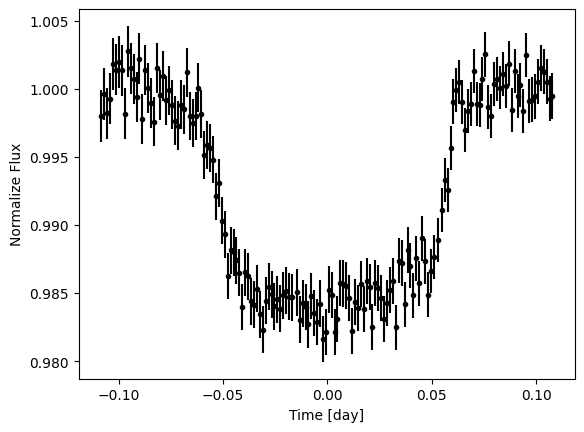

In [11]:
time = dat["col1"] - np.median(dat["col1"])
rel_mag = dat["col2"]
flux = 2.514**(1.0 - rel_mag)
err = dat["col3"]
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none")
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux")

In [12]:
def box_model(t, center_time, duration, depth, delta_flux):
  f = np.zeros(np.shape(t))
  ind = np.where(np.abs(t - center_time) < (duration / 2.0))
  f[ind] = 1.0 + delta_flux - depth
  ind = np.where(np.abs(t - center_time) >= (duration / 2.0))
  f[ind] = 1.0 + delta_flux
  return(f)

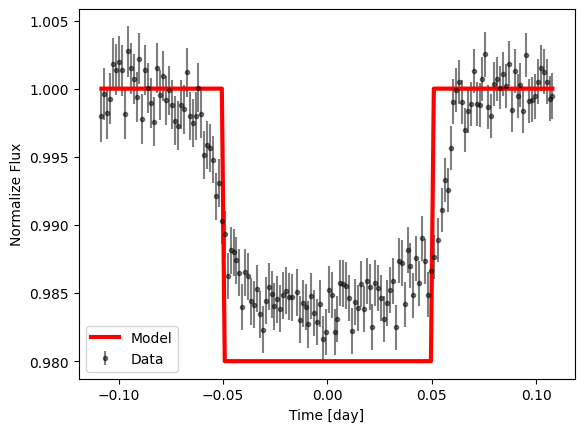

In [14]:
center_time, duration, depth, delta_flux = 0.0, 0.1, 0.02, 0.0
model = box_model(time, center_time, duration, depth, delta_flux)
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5, label="Data")
plt.plot(time, model, color="red", linewidth=3.0, label="Model")
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux")
plt.legend();

In [15]:
def log_likelihood(theta, x, y, yerr):
    center_time, duration, depth, delta_flux = theta
    model = box_model(time, center_time, duration, depth, delta_flux)
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [16]:
def log_prior(theta):
    center_time, duration, depth, delta_flux = theta
    if -0.05 < center_time < 0.05 and 0.0 < duration < 1.0 and 0.0 < depth < 1.0 and -0.1 < delta_flux < 0.1:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


In [17]:
! pip install -U emcee


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.3 MB/s eta 0:00:00


In [18]:
import emcee

pos = np.array([0.0, 0.1, 0.02, 0.0]) + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(time, flux, err)
)
sampler.run_mcmc(pos, 5000, progress=True);


100%|██████████| 5000/5000 [01:22<00:00, 60.97it/s]


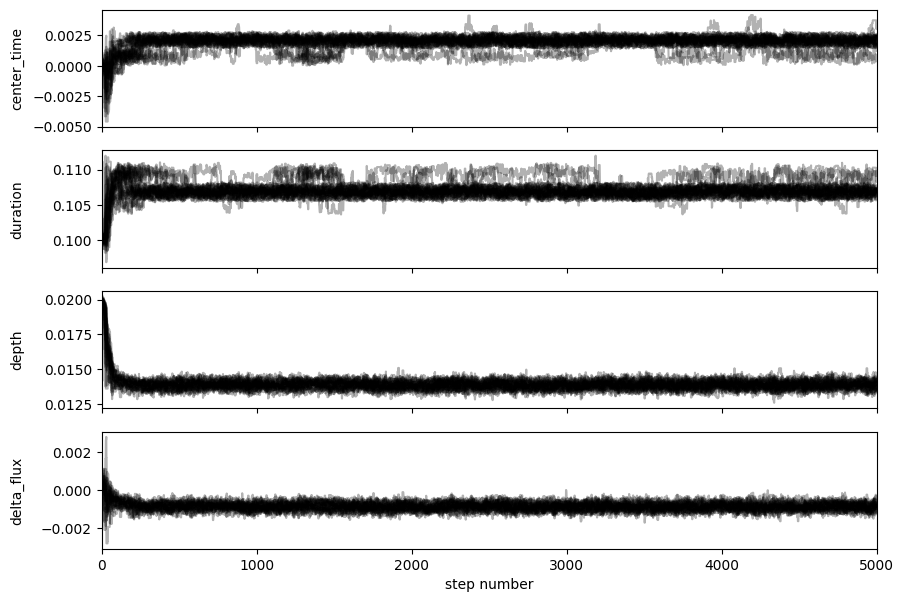

In [19]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["center_time", "duration", "depth", "delta_flux"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [21]:

flat_samples = sampler.get_chain(discard=100, thin=50, flat=True)
print(flat_samples.shape)

(3136, 4)


In [22]:
! pip install corner


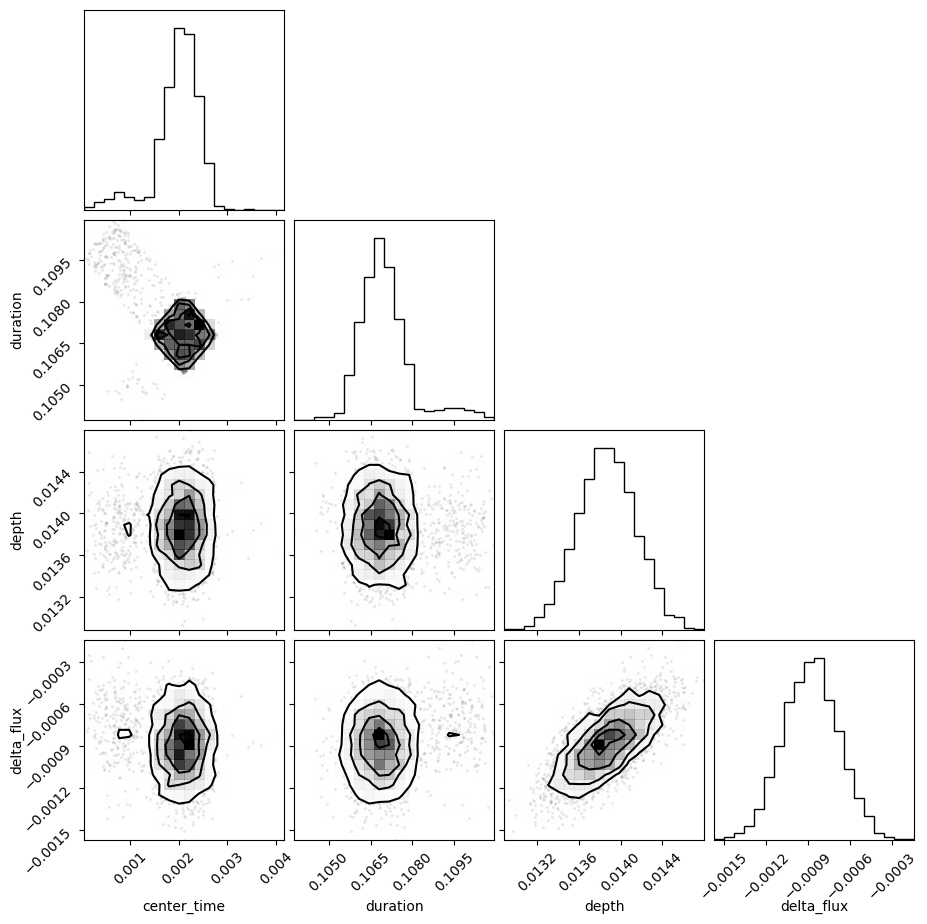

In [23]:
import corner
fig = corner.corner(flat_samples, labels=labels);

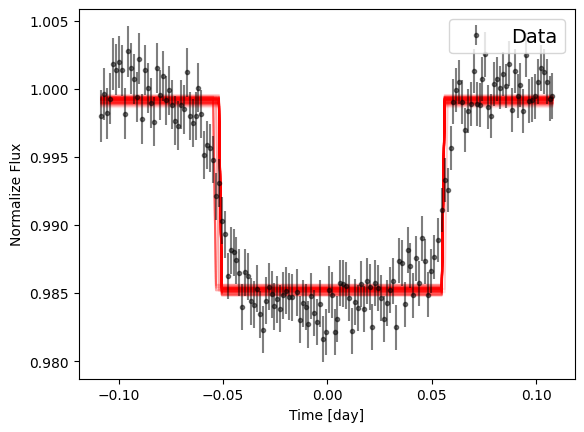

In [26]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    center_time, duration, depth, delta_flux = sample
    plt.plot(time, box_model(time, center_time, duration, depth, delta_flux), color="red", alpha=0.1)
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5, label="Data")
plt.legend(fontsize=14)
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux");


In [27]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

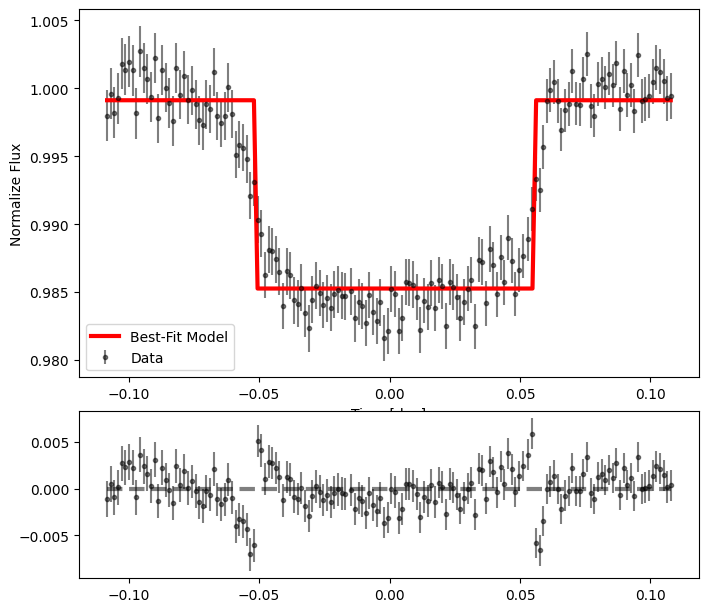

In [36]:
from matplotlib import gridspec
fig = plt.figure(figsize=(8, 10))
gs = gridspec.GridSpec(4, 1)

ax = fig.add_subplot(gs[1:3])
center_time, duration, depth, delta_flux = np.percentile(flat_samples, 50, axis=0)
model = box_model(time, center_time, duration, depth, delta_flux)
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5, label="Data")
plt.plot(time, model, color="red", linewidth=3.0, label="Best-Fit Model")
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux")
plt.legend();

ax = fig.add_subplot(gs[-1])
plt.errorbar(time, flux - model, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5)
plt.hlines(0, np.min(time), np.max(time), linestyle="dashed", linewidth=3.0, color="black", alpha=0.5)

In [37]:
def calculate_reduced_Chi2(flux, model, err, num_parameters):
  degree_freedom = len(flux) - num_parameters
  rChi2 = np.sum((flux - model)**2 / err**2) / degree_freedom
  return(rChi2)

In [38]:
print("Reduced Chi2 = ", calculate_reduced_Chi2(flux, model, err, 4))

Reduced Chi2 =  1.6072012649058827
